In [20]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon, norm
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import dirichlet
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [53]:
def para_x(u, s2, tao):
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    return sx, mux 
def document_generator(a, rho, T, s2, tao, N):
    '''
    Given the corpus, generate more documents.
    All corpus-level parameters are given.
    N: the number of documents.
    
    output: 
    X: N*d, X[i] = document[i]
    Y: Y[i] = label[i]
    G: membership
    U: transformed membership
    '''

    nlabel = len(T) # number of y
    d = len(tao[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        sx, mux = para_x(U[i], s2, tao)
        X.append(np.random.multivariate_normal(mux, sx))
    X = np.array(X)

    return X, Y, G, U

def check_p(a, rho, mu, s_inv):
    '''
    Input: the parameters used in the data
    1. Check whether a and rho will generate extremely small g
    2. See distributions of different topics
    '''
    ntopic = len(mu)
    g = np.random.dirichlet(a*rho, 100)
#     print("The minimum component of g is",g.min())
    
    print("Distribution of pure types")
    s = [np.linalg.inv(i) for i in s_inv]
    pX = np.concatenate(tuple([np.random.multivariate_normal(mu[i], s[i], 100) for i in range(ntopic)]))
    pY = [[i]*100 for i in range(ntopic)]
    fig_pure_type = plt.figure()
    ax = Axes3D(fig_pure_type)
    ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
    plt.show()

In [65]:
# set parameters
d = 30
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  1000, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
# trueU = sns.heatmap(np.dot(U,U.T))
# plt.title("true membership")
# plt.show()
# check_p(a, rho, mu, s_inv)

the value of a: 16.71234142066835


In [66]:
pca = PCA(n_components=20)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 20)
(500,)
training accuracy:  0.99
test accuracy:  0.964


In [68]:
pca = PCA(n_components=7)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 7)
(500,)
training accuracy:  0.972
test accuracy:  0.966


In [70]:
pca = PCA(n_components=1)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 1)
(500,)
training accuracy:  0.74
test accuracy:  0.746


(1000, 2)
(500,)
training accuracy:  0.904
test accuracy:  0.882


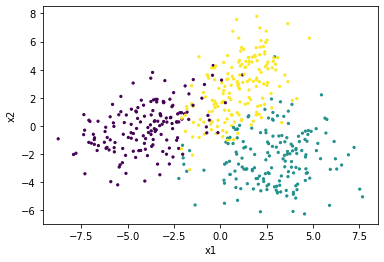

In [76]:
pca = PCA(n_components=2)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))
plt.scatter(trainX[:,0], trainX[:,1],c=trainY, s=5)
# plt.title("estimation error of rho")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [87]:
# set parameters
d = 50
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  1000, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)

the value of a: 1.531087456906219


In [88]:
pca = PCA(n_components=20)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 20)
(500,)
training accuracy:  0.654
test accuracy:  0.606


In [89]:
pca = PCA(n_components=10)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 10)
(500,)
training accuracy:  0.65
test accuracy:  0.586


In [81]:
pca = PCA(n_components=7)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(100, 7)
(50,)
training accuracy:  0.64
test accuracy:  0.58


(1000, 2)
(500,)
training accuracy:  0.378
test accuracy:  0.41


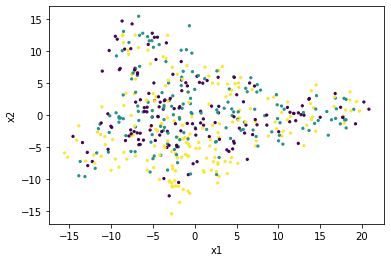

In [91]:
pca = PCA(n_components=2)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))
plt.scatter(trainX[:,0], trainX[:,1],c=trainY, s=5)
# plt.title("estimation error of rho")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [92]:
# set parameters
d = 100
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  1000, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
# trueU = sns.heatmap(np.dot(U,U.T))
# plt.title("true membership")
# plt.show()
# check_p(a, rho, mu, s_inv)

the value of a: 1.293248548409872


In [94]:
pca = PCA(n_components=20)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 20)
(500,)
training accuracy:  0.682
test accuracy:  0.634


In [108]:
# set parameters
d = 100
k0, k1 = 2,5
nlabel = 7
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  1000, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
# trueU = sns.heatmap(np.dot(U,U.T))
# plt.title("true membership")
# plt.show()
# check_p(a, rho, mu, s_inv)

the value of a: 3.3340691389019335


In [109]:
pca = PCA(n_components=20)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

(1000, 20)
(500,)
training accuracy:  0.364
test accuracy:  0.25


In [114]:
# set parameters
d = 100
k0, k1 = 5,2
nlabel = 7
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  1000, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
# trueU = sns.heatmap(np.dot(U,U.T))
# plt.title("true membership")
# plt.show()
# check_p(a, rho, mu, s_inv)
pca = PCA(n_components=20)
feature = pca.fit_transform(X)
print(feature.shape)
n = N//2
trainX = feature[:n]
testX = feature[n:]
trainY = Y[:n]
print(trainY.shape)
testY = Y[n:]
model = LogisticRegression(multi_class='multinomial')
model.fit(trainX, trainY)
print("training accuracy: ",model.score(trainX, trainY))
print("test accuracy: ", model.score(testX, testY))

the value of a: 20.341964899025697
(1000, 20)
(500,)
training accuracy:  1.0
test accuracy:  1.0
